In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import math

from torch.optim import Optimizer

In [2]:
# hyper parameters

input_size = 784 # 28x28
hidden_size = 100
num_classes = 10
num_epochs = 2
batch_size = 1000
learning_rate = 0.01

# Loading Data

In [4]:
# Download MNIST
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=False)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=False)

In [5]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

examples = iter(train_loader)
samples, labels = next(examples)
print(samples.shape, labels.shape)

torch.Size([1000, 1, 28, 28]) torch.Size([1000])


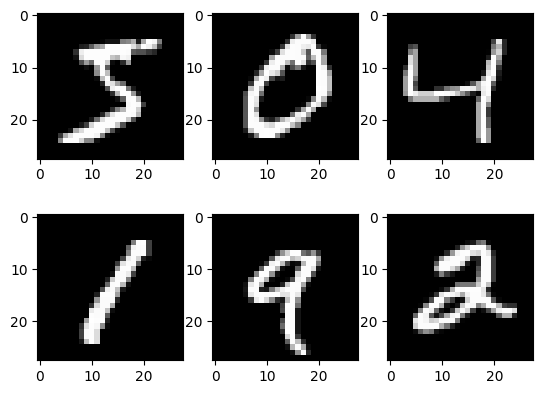

In [6]:
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(samples[i][0], cmap="gray")

In [7]:
labels[0:6]

tensor([5, 0, 4, 1, 9, 2])

# Model

In [8]:
class NeuralNet(nn.Module):
    def __init__(self,input_size,hidden_size,num_classes):
        super(NeuralNet,self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size,num_classes)
        
    def forward(self,x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return out
    

# Optimizer

In [9]:
class ourMethod(Optimizer):
    def __init__(self, parameters, lr=1e-3, n_directions = 2, device = "cpu"):
        defaults = {"lr": lr, "device":device}
        super().__init__(parameters, defaults)
        self.state['step'] = 0
        self.n_directions = n_directions
        self.ro = 0.02
        self.device = device
        for p in self.get_params():
            p.update_value = 0
      
    
    def get_params(self):
        return (p for group in self.param_groups for p in group['params'] if p.requires_grad)
 
        
    @torch.no_grad()
    def update_subspace(self,old_subSpace,new_gradient):
        if self.state['step'] < self.n_directions:
            new_subSpace = torch.cat([old_subSpace,new_gradient],1)
        else:
            new_subSpace = torch.cat([old_subSpace[:,1:],new_gradient],1)
        return new_subSpace
        
       
    
    def Hessian_v(self,grad,vec,p):                
        Hv = torch.autograd.grad(
        grad,
        p,
        grad_outputs=vec,
        only_inputs=True,
        retain_graph=True)
        
        Hv_flaten = []
        for i in range(len(Hv)):
            Hv_flaten.append(Hv[i].reshape(-1))
        return torch.cat(Hv_flaten,0).view(-1,1)
    
    
    
    def Hessian_M(self,grad,matrix,p):
        H_M = []
        for i in range(matrix.shape[1]):
            H_M.append(self.Hessian_v(grad,matrix[:,i].view(-1,1),p))
        return torch.cat(H_M,1)  
        
        
    @torch.no_grad()    
    def correction_Hessian(self,H):
        eig, U = torch.linalg.eigh(H)
        alfa = 0
        if eig.min() < self.ro:
            alfa = self.ro - eig.min()            
        return U, eig, alfa           
        
        
    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
                      
                

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                if self.state['step'] == 0:
                    d_p = p.grad
                    with torch.no_grad():
                        p.add_(d_p, alpha=-group['lr'])
                    p.subSpace = p.grad.data.view(-1,1)
                else:
                    flat_grad = p.grad.view(-1,1)
                    p.subSpace = self.update_subspace(p.subSpace,flat_grad.data)
                    Q, _ = torch.linalg.qr(p.subSpace.data)
                    HQ = self.Hessian_M(flat_grad,Q,p)
                    U, eig, alfa = self.correction_Hessian(Q.T@HQ)
                    y = U@torch.diag(1/(eig+alfa))@U.T@(Q.T@flat_grad)
                    d_p = Q@y
                    p.update_value = d_p.view_as(p.data)
                    
        
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                with torch.no_grad():
                    p.add_(p.update_value, alpha=-group['lr'])
                        
                        
        
        self.state['step'] += 1        
        return 

# Training Loop

In [10]:
def evaluate():
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        for images, labels in test_loader:
            images = images.reshape(-1,28*28)
            outputs = model(images)

            _,predictions = torch.max(outputs,1)
            n_samples += labels.shape[0]
            n_correct += (predictions == labels).sum().item()

        acc = 100.0*n_correct/n_samples

    print(f'accuracy = {acc}')
    return acc

In [11]:
model = NeuralNet(input_size,hidden_size,num_classes,)
criterion = nn.CrossEntropyLoss()
optimizer = ourMethod(model.parameters(), lr=0.1,n_directions=40)
acc_zero = evaluate()

accuracy = 9.19


In [12]:
n_total_steps = len(train_loader)
losses = []
iteration = 0
acc = []

num_epochs = 10
for epoch in range(num_epochs):
    for i, (images,labels) in enumerate(train_loader):
        images = images.reshape(-1,28*28)
        
        # forward:
        outputs = model(images)
        loss = criterion(outputs,labels)
        if iteration == 0:
            print(f'Initial loss = {loss.item():.4f}\n\n')
        
        # backwards:
        optimizer.zero_grad()
        loss.backward(create_graph=True)
        optimizer.step()
        
        losses.append([iteration,loss.item()])
        iteration += 1
        if (i+1) % 10 == 0:
            
            print(f'epoch {epoch+1} / {num_epochs}, step {i+1} / {n_total_steps}, loss = {loss.item():.4f}')
    acc.append(evaluate())


Initial loss = 2.3196




/Users/jogal/Library/Python/3.9/lib/python/site-packages/torch/autograd/__init__.py:197: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/engine.cpp:1064.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


epoch 1 / 10, step 10 / 60, loss = 0.9512
epoch 1 / 10, step 20 / 60, loss = 0.4910
epoch 1 / 10, step 30 / 60, loss = 0.4696
epoch 1 / 10, step 40 / 60, loss = 0.3978
epoch 1 / 10, step 50 / 60, loss = 0.4119
epoch 1 / 10, step 60 / 60, loss = 0.2445
accuracy = 92.02
epoch 2 / 10, step 10 / 60, loss = 0.2575
epoch 2 / 10, step 20 / 60, loss = 0.2163
epoch 2 / 10, step 30 / 60, loss = 0.2691
epoch 2 / 10, step 40 / 60, loss = 0.2506
epoch 2 / 10, step 50 / 60, loss = 0.3087
epoch 2 / 10, step 60 / 60, loss = 0.1627
accuracy = 94.29
epoch 3 / 10, step 10 / 60, loss = 0.1544
epoch 3 / 10, step 20 / 60, loss = 0.1571
epoch 3 / 10, step 30 / 60, loss = 0.1852
epoch 3 / 10, step 40 / 60, loss = 0.1791
epoch 3 / 10, step 50 / 60, loss = 0.2330
epoch 3 / 10, step 60 / 60, loss = 0.1274
accuracy = 95.53
epoch 4 / 10, step 10 / 60, loss = 0.1070
epoch 4 / 10, step 20 / 60, loss = 0.1275
epoch 4 / 10, step 30 / 60, loss = 0.1354
epoch 4 / 10, step 40 / 60, loss = 0.1442
epoch 4 / 10, step 50 / 6

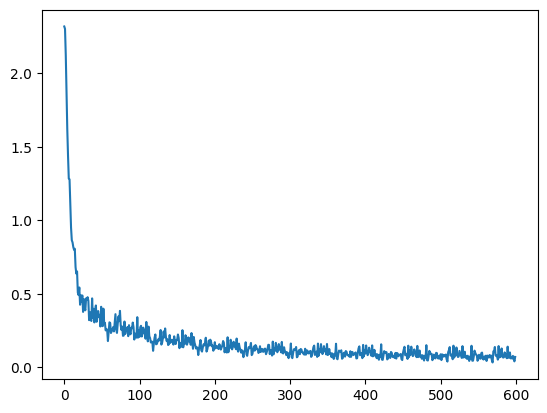

In [13]:
losses_arr = np.array(losses)
plt.plot(losses_arr[:,0],losses_arr[:,1])

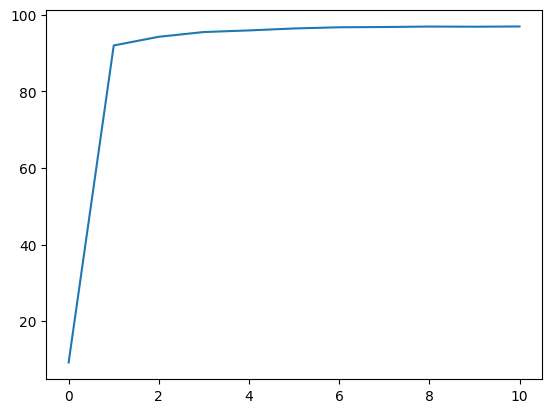

In [14]:
plt.plot(np.append(acc_zero,acc))

# AdaHessian

In [15]:
class Adahessian(Optimizer):
    """Implements Adahessian algorithm.
    It has been proposed in `ADAHESSIAN: An Adaptive Second Order Optimizer for Machine Learning`.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 0.15)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-4)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        hessian_power (float, optional): Hessian power (default: 1). You can also try 0.5. For some tasks we found this to result in better performance.
        single_gpu (Bool, optional): Do you use distributed training or not "torch.nn.parallel.DistributedDataParallel" (default: True)
    """

    def __init__(self, params, lr=0.15, betas=(0.9, 0.999), eps=1e-4,
                 weight_decay=0, hessian_power=1, single_gpu=True):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError(
                "Invalid beta parameter at index 0: {}".format(
                    betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError(
                "Invalid beta parameter at index 1: {}".format(
                    betas[1]))
        if not 0.0 <= hessian_power <= 1.0:
            raise ValueError("Invalid Hessian power value: {}".format(hessian_power))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, hessian_power=hessian_power)
        self.single_gpu = single_gpu 
        super(Adahessian, self).__init__(params, defaults)

    def get_trace(self, params, grads):
        """
        compute the Hessian vector product with a random vector v, at the current gradient point,
        i.e., compute the gradient of <gradsH,v>.
        :param gradsH: a list of torch variables
        :return: a list of torch tensors
        """

        # Check backward was called with create_graph set to True
        for i, grad in enumerate(grads):
            if grad.grad_fn is None:
                raise RuntimeError('Gradient tensor {:} does not have grad_fn. When calling\n'.format(i) +
                           '\t\t\t  loss.backward(), make sure the option create_graph is\n' +
                           '\t\t\t  set to True.')

        v = [2 * torch.randint_like(p, high=2) - 1 for p in params]

        # this is for distributed setting with single node and multi-gpus, 
        # for multi nodes setting, we have not support it yet.
        if not self.single_gpu:
            for v1 in v:
                dist.all_reduce(v1)
        if not self.single_gpu:
            for v_i in v:
                v_i[v_i < 0.] = -1.
                v_i[v_i >= 0.] = 1.

        hvs = torch.autograd.grad(
            grads,
            params,
            grad_outputs=v,
            only_inputs=True,
            retain_graph=True)

        hutchinson_trace = []
        for hv in hvs:
            param_size = hv.size()
            if len(param_size) <= 2:  # for 0/1/2D tensor
                # Hessian diagonal block size is 1 here.
                # We use that torch.abs(hv * vi) = hv.abs()
                tmp_output = hv.abs()

            elif len(param_size) == 4:  # Conv kernel
                # Hessian diagonal block size is 9 here: torch.sum() reduces the dim 2/3.
                # We use that torch.abs(hv * vi) = hv.abs()
                tmp_output = torch.mean(hv.abs(), dim=[2, 3], keepdim=True)
            hutchinson_trace.append(tmp_output)

        # this is for distributed setting with single node and multi-gpus, 
        # for multi nodes setting, we have not support it yet.
        if not self.single_gpu:
            for output1 in hutchinson_trace:
                dist.all_reduce(output1 / torch.cuda.device_count())
        
        return hutchinson_trace

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            gradsH: The gradient used to compute Hessian vector product.
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        params = []
        groups = []
        grads = []

        # Flatten groups into lists, so that
        #  hut_traces can be called with lists of parameters
        #  and grads 
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    params.append(p)
                    groups.append(group)
                    grads.append(p.grad)

        # get the Hessian diagonal

        hut_traces = self.get_trace(params, grads)

        for (p, group, grad, hut_trace) in zip(params, groups, grads, hut_traces):

            state = self.state[p]

            # State initialization
            if len(state) == 0:
                state['step'] = 0
                # Exponential moving average of gradient values
                state['exp_avg'] = torch.zeros_like(p.data)
                # Exponential moving average of Hessian diagonal square values
                state['exp_hessian_diag_sq'] = torch.zeros_like(p.data)

            exp_avg, exp_hessian_diag_sq = state['exp_avg'], state['exp_hessian_diag_sq']

            beta1, beta2 = group['betas']

            state['step'] += 1

            # Decay the first and second moment running average coefficient
            exp_avg.mul_(beta1).add_(grad.detach_(), alpha=1 - beta1)
            exp_hessian_diag_sq.mul_(beta2).addcmul_(hut_trace, hut_trace, value=1 - beta2)

            bias_correction1 = 1 - beta1 ** state['step']
            bias_correction2 = 1 - beta2 ** state['step']

            # make the square root, and the Hessian power
            k = group['hessian_power']
            denom = (
                (exp_hessian_diag_sq.sqrt() ** k) /
                math.sqrt(bias_correction2) ** k).add_(
                group['eps'])

            # make update
            p.data = p.data - \
                group['lr'] * (exp_avg / bias_correction1 / denom + group['weight_decay'] * p.data)

        return loss

In [16]:
model = NeuralNet(input_size,hidden_size,num_classes,)
criterion = nn.CrossEntropyLoss()
optimizer = Adahessian(model.parameters(), lr=0.05)
acc_zero_ada = evaluate()

accuracy = 9.69


In [17]:
n_total_steps = len(train_loader)
losses_ada = []
iteration = 0
acc_ada = []

num_epochs = 10
for epoch in range(num_epochs):
    for i, (images,labels) in enumerate(train_loader):
        images = images.reshape(-1,28*28)
        
        # forward:
        outputs = model(images)
        loss = criterion(outputs,labels)
        if iteration == 0:
            print(f'Initial loss = {loss.item():.4f}\n\n')
        
        # backwards:
        optimizer.zero_grad()
        loss.backward(create_graph=True)
        optimizer.step()
        
        losses_ada.append([iteration,loss.item()])
        iteration += 1
        if (i+1) % 10 == 0:
            
            print(f'epoch {epoch+1} / {num_epochs}, step {i+1} / {n_total_steps}, loss = {loss.item():.4f}')
    acc_ada.append(evaluate())


Initial loss = 2.3262


epoch 1 / 10, step 10 / 60, loss = 0.7406
epoch 1 / 10, step 20 / 60, loss = 0.4983
epoch 1 / 10, step 30 / 60, loss = 0.5190
epoch 1 / 10, step 40 / 60, loss = 0.4567
epoch 1 / 10, step 50 / 60, loss = 0.4728
epoch 1 / 10, step 60 / 60, loss = 0.2564
accuracy = 90.78
epoch 2 / 10, step 10 / 60, loss = 0.3043
epoch 2 / 10, step 20 / 60, loss = 0.2765
epoch 2 / 10, step 30 / 60, loss = 0.3467
epoch 2 / 10, step 40 / 60, loss = 0.3347
epoch 2 / 10, step 50 / 60, loss = 0.3563
epoch 2 / 10, step 60 / 60, loss = 0.1998
accuracy = 92.81
epoch 3 / 10, step 10 / 60, loss = 0.2425
epoch 3 / 10, step 20 / 60, loss = 0.2160
epoch 3 / 10, step 30 / 60, loss = 0.2791
epoch 3 / 10, step 40 / 60, loss = 0.2693
epoch 3 / 10, step 50 / 60, loss = 0.2958
epoch 3 / 10, step 60 / 60, loss = 0.1680
accuracy = 93.72
epoch 4 / 10, step 10 / 60, loss = 0.2040
epoch 4 / 10, step 20 / 60, loss = 0.1844
epoch 4 / 10, step 30 / 60, loss = 0.2365
epoch 4 / 10, step 40 / 60, loss = 0.2280
e

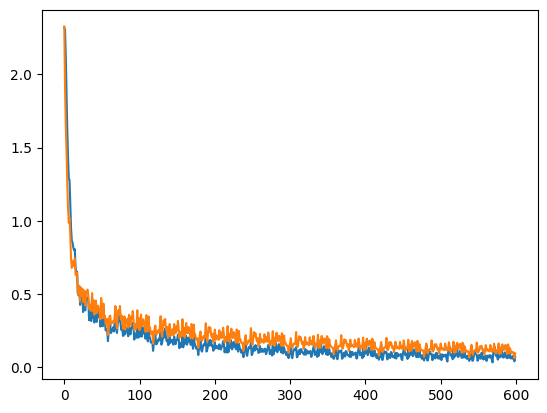

In [18]:
losses_arr_ada = np.array(losses_ada)
plt.plot(losses_arr[:,0],losses_arr[:,1])
plt.plot(losses_arr_ada[:,0],losses_arr_ada[:,1])

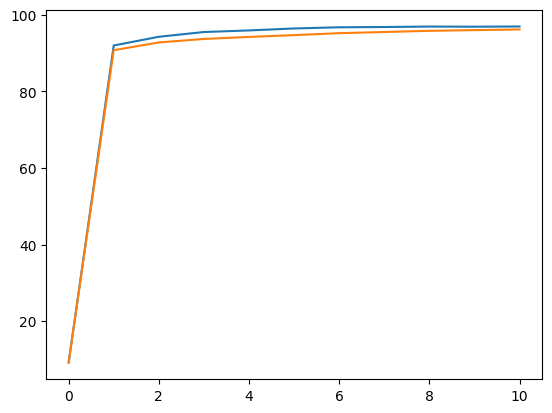

In [19]:
plt.plot(np.append(acc_zero,acc))
plt.plot(np.append(acc_zero,acc_ada))

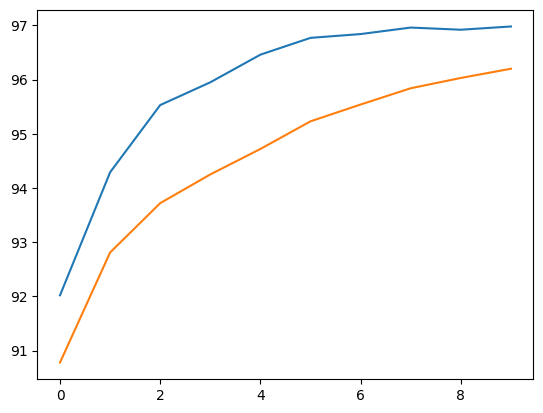

In [20]:
plt.plot(acc)
plt.plot(acc_ada)

# Adam

In [21]:
model = NeuralNet(input_size,hidden_size,num_classes,)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [22]:
n_total_steps = len(train_loader)
losses_adam = []
iteration = 0
acc_adam = []

num_epochs = 10
for epoch in range(num_epochs):
    for i, (images,labels) in enumerate(train_loader):
        images = images.reshape(-1,28*28)
        
        # forward:
        outputs = model(images)
        loss = criterion(outputs,labels)
        if iteration == 0:
            print(f'Initial loss = {loss.item():.4f}\n\n')
        
        # backwards:
        optimizer.zero_grad()
        loss.backward(create_graph=True)
        optimizer.step()
        
        losses_adam.append([iteration,loss.item()])
        iteration += 1
        if (i+1) % 10 == 0:
            
            print(f'epoch {epoch+1} / {num_epochs}, step {i+1} / {n_total_steps}, loss = {loss.item():.4f}')
    acc_adam.append(evaluate())


Initial loss = 2.3039


epoch 1 / 10, step 10 / 60, loss = 1.7429
epoch 1 / 10, step 20 / 60, loss = 1.1705
epoch 1 / 10, step 30 / 60, loss = 0.8855
epoch 1 / 10, step 40 / 60, loss = 0.6584
epoch 1 / 10, step 50 / 60, loss = 0.6197
epoch 1 / 10, step 60 / 60, loss = 0.3477
accuracy = 88.87
epoch 2 / 10, step 10 / 60, loss = 0.3817
epoch 2 / 10, step 20 / 60, loss = 0.3645
epoch 2 / 10, step 30 / 60, loss = 0.4267
epoch 2 / 10, step 40 / 60, loss = 0.3870
epoch 2 / 10, step 50 / 60, loss = 0.4238
epoch 2 / 10, step 60 / 60, loss = 0.2369
accuracy = 91.35
epoch 3 / 10, step 10 / 60, loss = 0.2928
epoch 3 / 10, step 20 / 60, loss = 0.2744
epoch 3 / 10, step 30 / 60, loss = 0.3458
epoch 3 / 10, step 40 / 60, loss = 0.3270
epoch 3 / 10, step 50 / 60, loss = 0.3657
epoch 3 / 10, step 60 / 60, loss = 0.2060
accuracy = 92.05
epoch 4 / 10, step 10 / 60, loss = 0.2543
epoch 4 / 10, step 20 / 60, loss = 0.2344
epoch 4 / 10, step 30 / 60, loss = 0.3024
epoch 4 / 10, step 40 / 60, loss = 0.2925
e

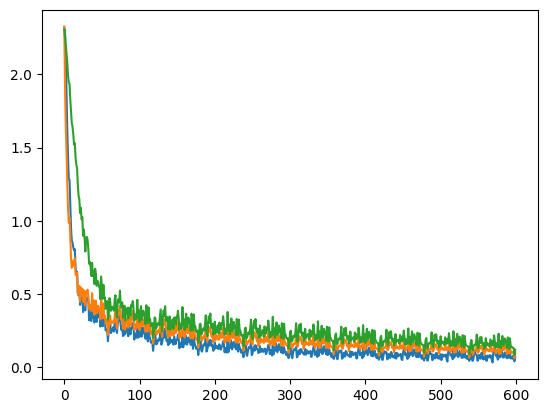

In [23]:
losses_arr_adam = np.array(losses_adam)
plt.plot(losses_arr[:,0],losses_arr[:,1])
plt.plot(losses_arr_ada[:,0],losses_arr_ada[:,1])
plt.plot(losses_arr_adam[:,0],losses_arr_adam[:,1])

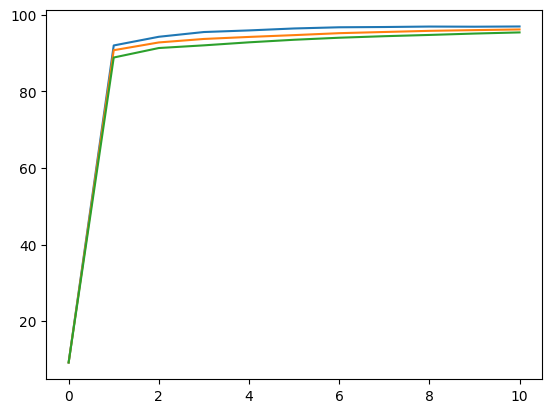

In [24]:
plt.plot(np.append(acc_zero,acc))
plt.plot(np.append(acc_zero,acc_ada))
plt.plot(np.append(acc_zero,acc_adam))

# AdaGrad

In [25]:
model = NeuralNet(input_size,hidden_size,num_classes,)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)

In [26]:
n_total_steps = len(train_loader)
losses_adagrad = []
iteration = 0
acc_adagrad = []

num_epochs = 10
for epoch in range(num_epochs):
    for i, (images,labels) in enumerate(train_loader):
        images = images.reshape(-1,28*28)
        
        # forward:
        outputs = model(images)
        loss = criterion(outputs,labels)
        if iteration == 0:
            print(f'Initial loss = {loss.item():.4f}\n\n')
        
        # backwards:
        optimizer.zero_grad()
        loss.backward(create_graph=True)
        optimizer.step()
        
        losses_adagrad.append([iteration,loss.item()])
        iteration += 1
        if (i+1) % 10 == 0:
            
            print(f'epoch {epoch+1} / {num_epochs}, step {i+1} / {n_total_steps}, loss = {loss.item():.4f}')
    acc_adagrad.append(evaluate())


Initial loss = 2.3149


epoch 1 / 10, step 10 / 60, loss = 0.7264
epoch 1 / 10, step 20 / 60, loss = 0.5016
epoch 1 / 10, step 30 / 60, loss = 0.5103
epoch 1 / 10, step 40 / 60, loss = 0.4574
epoch 1 / 10, step 50 / 60, loss = 0.4772
epoch 1 / 10, step 60 / 60, loss = 0.2699
accuracy = 90.62
epoch 2 / 10, step 10 / 60, loss = 0.3206
epoch 2 / 10, step 20 / 60, loss = 0.3053
epoch 2 / 10, step 30 / 60, loss = 0.3639
epoch 2 / 10, step 40 / 60, loss = 0.3530
epoch 2 / 10, step 50 / 60, loss = 0.3869
epoch 2 / 10, step 60 / 60, loss = 0.2172
accuracy = 91.98
epoch 3 / 10, step 10 / 60, loss = 0.2717
epoch 3 / 10, step 20 / 60, loss = 0.2569
epoch 3 / 10, step 30 / 60, loss = 0.3142
epoch 3 / 10, step 40 / 60, loss = 0.3136
epoch 3 / 10, step 50 / 60, loss = 0.3459
epoch 3 / 10, step 60 / 60, loss = 0.1927
accuracy = 92.67
epoch 4 / 10, step 10 / 60, loss = 0.2452
epoch 4 / 10, step 20 / 60, loss = 0.2314
epoch 4 / 10, step 30 / 60, loss = 0.2846
epoch 4 / 10, step 40 / 60, loss = 0.2885
e

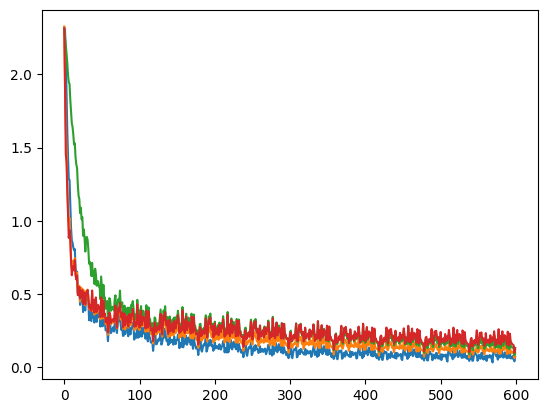

In [27]:
losses_arr_adagrad = np.array(losses_adagrad)
plt.plot(losses_arr[:,0],losses_arr[:,1])
plt.plot(losses_arr_ada[:,0],losses_arr_ada[:,1])
plt.plot(losses_arr_adam[:,0],losses_arr_adam[:,1])
plt.plot(losses_arr_adagrad[:,0],losses_arr_adagrad[:,1])

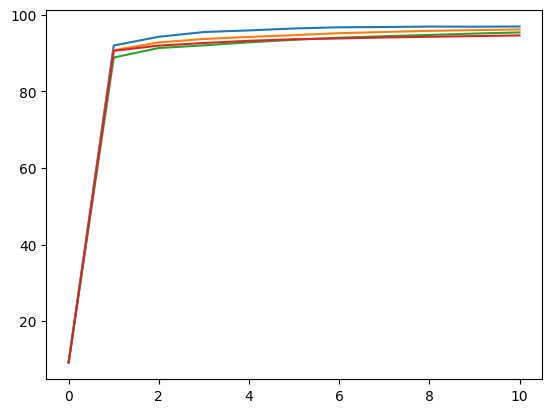

In [28]:
plt.plot(np.append(acc_zero,acc))
plt.plot(np.append(acc_zero,acc_ada))
plt.plot(np.append(acc_zero,acc_adam))
plt.plot(np.append(acc_zero,acc_adagrad))

# SGD

In [29]:
model = NeuralNet(input_size,hidden_size,num_classes,)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [30]:
n_total_steps = len(train_loader)
losses_sgd = []
iteration = 0
acc_sgd = []

num_epochs = 10
for epoch in range(num_epochs):
    for i, (images,labels) in enumerate(train_loader):
        images = images.reshape(-1,28*28)
        
        # forward:
        outputs = model(images)
        loss = criterion(outputs,labels)
        if iteration == 0:
            print(f'Initial loss = {loss.item():.4f}\n\n')
        
        # backwards:
        optimizer.zero_grad()
        loss.backward(create_graph=True)
        optimizer.step()
        
        losses_sgd.append([iteration,loss.item()])
        iteration += 1
        if (i+1) % 10 == 0:
            
            print(f'epoch {epoch+1} / {num_epochs}, step {i+1} / {n_total_steps}, loss = {loss.item():.4f}')
    acc_sgd.append(evaluate())


Initial loss = 2.3130


epoch 1 / 10, step 10 / 60, loss = 2.1379
epoch 1 / 10, step 20 / 60, loss = 1.8801
epoch 1 / 10, step 30 / 60, loss = 1.6034
epoch 1 / 10, step 40 / 60, loss = 1.2941
epoch 1 / 10, step 50 / 60, loss = 1.1353
epoch 1 / 10, step 60 / 60, loss = 0.7773
accuracy = 82.93
epoch 2 / 10, step 10 / 60, loss = 0.7367
epoch 2 / 10, step 20 / 60, loss = 0.6773
epoch 2 / 10, step 30 / 60, loss = 0.7119
epoch 2 / 10, step 40 / 60, loss = 0.6419
epoch 2 / 10, step 50 / 60, loss = 0.6585
epoch 2 / 10, step 60 / 60, loss = 0.4223
accuracy = 87.35
epoch 3 / 10, step 10 / 60, loss = 0.4773
epoch 3 / 10, step 20 / 60, loss = 0.4697
epoch 3 / 10, step 30 / 60, loss = 0.5423
epoch 3 / 10, step 40 / 60, loss = 0.5070
epoch 3 / 10, step 50 / 60, loss = 0.5409
epoch 3 / 10, step 60 / 60, loss = 0.3343
accuracy = 88.85
epoch 4 / 10, step 10 / 60, loss = 0.3998
epoch 4 / 10, step 20 / 60, loss = 0.3968
epoch 4 / 10, step 30 / 60, loss = 0.4763
epoch 4 / 10, step 40 / 60, loss = 0.4501
e

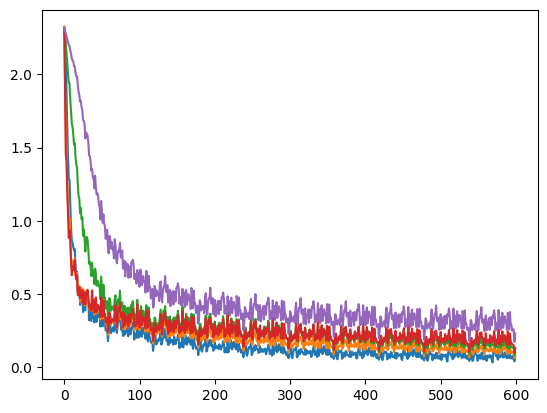

In [31]:
losses_arr_sgd = np.array(losses_sgd)
plt.plot(losses_arr[:,0],losses_arr[:,1])
plt.plot(losses_arr_ada[:,0],losses_arr_ada[:,1])
plt.plot(losses_arr_adam[:,0],losses_arr_adam[:,1])
plt.plot(losses_arr_adagrad[:,0],losses_arr_adagrad[:,1])
plt.plot(losses_arr_sgd[:,0],losses_arr_sgd[:,1])

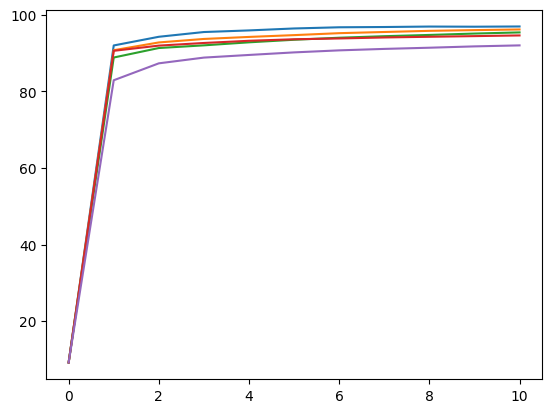

In [32]:
plt.plot(np.append(acc_zero,acc))
plt.plot(np.append(acc_zero,acc_ada))
plt.plot(np.append(acc_zero,acc_adam))
plt.plot(np.append(acc_zero,acc_adagrad))
plt.plot(np.append(acc_zero,acc_sgd))

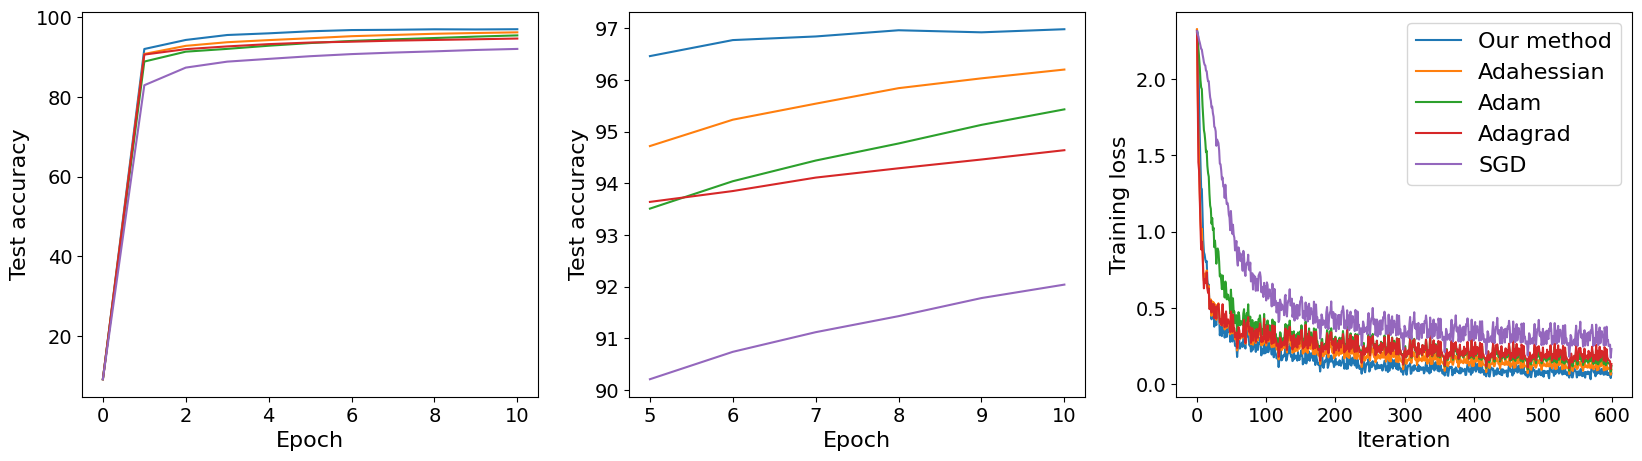

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,5))


ax[0].plot(np.append(acc_zero,acc))
ax[0].plot(np.append(acc_zero,acc_ada))
ax[0].plot(np.append(acc_zero,acc_adam))
ax[0].plot(np.append(acc_zero,acc_adagrad))
ax[0].plot(np.append(acc_zero,acc_sgd))

ax[1].plot([5,6,7,8,9,10],np.append(acc_zero,acc)[5:])
ax[1].plot([5,6,7,8,9,10],np.append(acc_zero,acc_ada)[5:])
ax[1].plot([5,6,7,8,9,10],np.append(acc_zero,acc_adam)[5:])
ax[1].plot([5,6,7,8,9,10],np.append(acc_zero,acc_adagrad)[5:])
ax[1].plot([5,6,7,8,9,10],np.append(acc_zero,acc_sgd)[5:])


ax[2].plot(losses_arr[:,1])
ax[2].plot(losses_arr_ada[:,1])
ax[2].plot(losses_arr_adam[:,1])
ax[2].plot(losses_arr_adagrad[:,1])
ax[2].plot(losses_arr_sgd[:,1])



legend = [
          "Our method",
          "Adahessian",
          "Adam",
          "Adagrad",
          "SGD",

             ]

plt.legend(legend,fontsize=16)



ax[0].set_xlabel("Epoch",fontsize=16)
ax[0].set_ylabel("Test accuracy",fontsize=16)
ax[1].set_xlabel("Epoch",fontsize=16)
ax[1].set_ylabel("Test accuracy",fontsize=16)
ax[2].set_ylabel("Training loss",fontsize=16)
ax[2].set_xlabel("Iteration",fontsize=16)

ax[0].tick_params(axis="x", labelsize=14) 
ax[0].tick_params(axis="y", labelsize=14) 
ax[1].tick_params(axis="x", labelsize=14) 
ax[1].tick_params(axis="y", labelsize=14) 
ax[2].tick_params(axis="x", labelsize=14) 
ax[2].tick_params(axis="y", labelsize=14) 

plt.savefig('experiment2.pdf')  


#fig.suptitle('Fully connected neural network on MNIST ',fontsize=32)